# 맛집 크롤링
## 맛집 정보를 알려주는 사이트
구글에 `맛집 정보`로 검색을 하면 여러개 맛집 사이트를 찾을 수 있다.
* http://www.menupan.com/
* https://www.diningcode.com/
* https://www.mangoplate.com/
* https://www.siksinhot.com/

이중에서 가장 정보를 많이 얻을 수 있는 사이트를 크롤링 하기로 결정했다.
### menupan
가격대, 위치, 전화번호, 업종, 메뉴, `분위기`, `테마`가 제공이 된다

상세 정보에는 위치가 다음이 쓰고 있는 콩나물좌표계를 쓰고 있어서 위경도로 변환을 하는 데에 어려움이 있을 것 같았지만 다른 페이지에는 WGS84좌표계(위경도)를 사용하고 있었다.
### diningcode
음식점의 정확한 위치(위경도)를 찾을 수 없는 것 같다.
### mangoplate
리뷰, 평점, 위치, 전화번호, 가격대, 메뉴 등이 제공이 된다.
### siksinhot
리뷰, 평점, 영업시간, 전화번호, 메뉴
별 매장 히스토리, 편의시설, `태그` 등이 있다.

여기서 menupan서비스가 가장 정보를 많이 얻을 수 있는 것 같다.
requests모듈과 BeautifulSoup를 사용해서 크롤링을 할 예정이다.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib import parse
import re
import itertools
from typing import List
import numpy as np
import cv2
import matplotlib.pyplot as plt
import folium

plt.rcParams['font.family'] = 'Pretendard'

def make_soup(url):
  """
    GET 요청을 보내고 BeautifulSoup 객체를 반환
  """
  res = requests.get(url)
  return BeautifulSoup(res.text)


## 맛집 검색하기
`http://www.menupan.com/search/restaurant/restaurant_result.asp?sc=basicdata&kw={검색어}`로 이루어져있다.

In [2]:
search_keyword = '피자'
base_url = 'http://www.menupan.com'
soup = make_soup(f'{base_url}/search/restaurant/restaurant_result.asp?sc=basicdata&kw={search_keyword}')

In [3]:
# 어라라.. 검색 결과가 없다..
soup.select('#searchContent_Inner > div.section > ul > li')

[]

In [4]:
# 검색 결과가 없다고 뜬다
soup.select('#searchContent_Inner')

[<div id="searchContent_Inner">
 <!--검색결과 없을때-->
 <div class="section">
 <dl class="listStyle5">
 <dt><span>'?쇱��'</span>에 대한 검색결과가 없습니다.</dt>
 <dd>
 <ul>
 <li>단어의 철자가 정확한지 확인해 주세요. </li>
 <li>검색어의 단어 수를 줄이거나, 다른 검색어로 검색해 보세요. </li>
 <li>보다 일반적인 검색어로 다시 검색해 보세요. </li>
 </ul>
 </dd>
 </dl></div>
 <!--//검색결과 없을때 끝-->
 </div>]

`~에 대한 검색 결과가 없습니다`앞에 이상한 문자가 있는 것으로 봐서는 인코딩 관련 에러인 것 같다.  
urllib를 사용해서 해결할 수 있다.

In [5]:
soup = make_soup(f'{base_url}/search/restaurant/restaurant_result.asp?sc=basicdata&kw={parse.quote(search_keyword)}')
soup.select('#searchContent_Inner')

[<div id="searchContent_Inner">
 <!--검색결과 없을때-->
 <div class="section">
 <dl class="listStyle5">
 <dt><span>'?쇱��'</span>에 대한 검색결과가 없습니다.</dt>
 <dd>
 <ul>
 <li>단어의 철자가 정확한지 확인해 주세요. </li>
 <li>검색어의 단어 수를 줄이거나, 다른 검색어로 검색해 보세요. </li>
 <li>보다 일반적인 검색어로 다시 검색해 보세요. </li>
 </ul>
 </dd>
 </dl></div>
 <!--//검색결과 없을때 끝-->
 </div>]

아무래도 정상적인 URL은 아닌 것 같다.  
`피자`라고 검색을 했을 때 `%C7%C7%C0%DA`라고 나오는데 전형적인 한글 URL encoding과는 거리가 좀 있다.  
이 페이지가 utf-8이 아닌 euc-kr을 사용하고 있어서 있어나는 문제인데 `피자`라는 문자를 euc-kr로 인코딩하면 될 것 같다

In [6]:
# 매우 잘 된다
soup = make_soup(f'{base_url}/search/restaurant/restaurant_result.asp?sc=basicdata&kw={parse.quote(search_keyword, encoding="euc-kr")}')
soup.select('#searchContent_Inner')

[<div id="searchContent_Inner">
 <div class="sectionTop">
 <h2>맛집</h2>
 </div>
 <div class="section">
 <div class="selectBlock">
 <div class="searchCount">전체 글: 648건, 현재페이지: 1/44</div> <div class="radioBlock">
 <div class="inner">
 <h4>업종</h4>
 <ul class="radioList">
 <li><input checked="checked" class="radio" name="fit" onclick="go_Page('/search/restaurant/restaurant_result.asp','basicdata','피자','',this.value,'');" type="radio" value=""/><label class="fcB03" for="all">전체</label></li>
 <li><input class="radio" name="fit" onclick="go_Page('/search/restaurant/restaurant_result.asp','basicdata','피자','',this.value,'');" type="radio" value="10"/><label for="rest1">한식</label></li>
 <li><input class="radio" name="fit" onclick="go_Page('/search/restaurant/restaurant_result.asp','basicdata','피자','',this.value,'');" type="radio" value="20"/><label for="rest2">양식</label></li>
 <li><input class="radio" name="fit" onclick="go_Page('/search/restaurant/restaurant_result.asp','basicdata','피자','',this.

### 검색 결과 가져오기
검색 결과를 보여주는 사이트에서는 이름, 메뉴 소개, 주소, 전화번호, 사진 등을 가져올 수 있다.

In [7]:
restaurants = soup.select('#searchContent_Inner > div.section > ul > li')
restaurants = [{
  'image': restaurant.find('img')['src'],
  **((lambda data: {
    'name': data.get_text(),
    'link': data['href'],
  })(restaurant.select_one('dl > dt > a'))),
  **((lambda data: {
    'part': data[0],
    'menus': data[1].split(', '),
  })(restaurant.select_one('.sum3').get_text().split(' |'))),
  **((lambda data: {
    'address': data[0],
    'tel': data[1],
  })(restaurant.select_one('.sum').get_text().split(' | '))),
} for restaurant in restaurants]
restaurants

[{'image': '/restaurant/restimg/002/ssimg/f101182a_s.jpg',
  'name': '미스터피자(Mr.Pizza) 여의도점',
  'link': '/Restaurant/Onepage.asp?acode=F101182',
  'part': '패스트푸드>피자',
  'menus': ['하프앤하프(R)', '치즈스페셜(오리진/R)', '치즈스페셜(치즈캡/R)'],
  'address': '서울 영등포구 여의도동 37 아일렉스상가',
  'tel': '02-784-0005'},
 {'image': '/restaurant/restimg/000/ssimg/r106770a_s.jpg',
  'name': '명동피자 본점',
  'link': '/Restaurant/Onepage.asp?acode=R106770',
  'part': '양식>이탈리아음식',
  'menus': ['뽀빠이 피자', '디아볼라 피자', '크레마 감베리 펜네'],
  'address': '서울 중구 충무로1가 22-2 우림빌딩 지하',
  'tel': '02-777-8979'},
 {'image': '/restaurant/restimg/006/ssimg/r200086a_s.jpg',
  'name': '부오나피자 강릉점',
  'link': '/Restaurant/Onepage.asp?acode=R200086',
  'part': '양식>패밀리레스토랑',
  'menus': ['화덕 엘레강스 피자', '숯불 바베큐 골드 피자', '빠네 파스타'],
  'address': '강원 강릉시 교동 1822-2',
  'tel': '033-651-0324'},
 {'image': '/restaurant/restimg/009/ssimg/b102259a_s.jpg',
  'name': '파파화덕피자&바로떡볶이',
  'link': '/Restaurant/Onepage.asp?acode=B102259',
  'part': '분식',
  'menus': ['세트A', '세트B'

### 검색결과 더 가져오기
하지만 여기서 만족할 수 없다.  
가져온 결과는 15개 밖에 되지 않지만 전국에 피자집이 15개 밖에 없을까,,

In [8]:
len(restaurants)

15

페이지를 보면 `전체 글`과 `현재 페이지`라는 부분이 있고 그 만큼 요청을 반복해서 모든 결과를 가져올 것이다.

In [9]:
page_count = int(re.compile('현재페이지: 1/(\d+)').search(soup.select_one('.searchCount').get_text()).group(1))
page_count

44

가져오는 부분을 하나로 합쳐서 함수로 만들고,

In [10]:
def search_restaurants(keyword: str, page: int = 1):
  soup = make_soup(f'{base_url}/search/restaurant/restaurant_result.asp?sc=basicdata&kw={parse.quote(search_keyword, encoding="euc-kr")}&page={page}')
  soup.select('#searchContent_Inner')
  restaurants = soup.select('#searchContent_Inner > div.section > ul > li')
  restaurants = [{
    'image': restaurant.find('img')['src'],
    **((lambda data: {
      'name': data.get_text(),
      'link': re.compile('acode=(.*)').search(data['href']).group(1),
    })(restaurant.select_one('dl > dt > a'))),
    **((lambda data: {
      'part': data[0],
      'menus': data[1].split(', '),
    })(restaurant.select_one('.sum3').get_text().split(' |'))),
    **((lambda data: {
      'address': data[0],
      'tel': data[1],
    })(restaurant.select_one('.sum').get_text().split(' | '))),
  } for restaurant in restaurants]
  return restaurants

In [11]:
# 잘 돌아간다
search_restaurants('피자')

[{'image': '/restaurant/restimg/002/ssimg/f101182a_s.jpg',
  'name': '미스터피자(Mr.Pizza) 여의도점',
  'link': 'F101182',
  'part': '패스트푸드>피자',
  'menus': ['하프앤하프(R)', '치즈스페셜(오리진/R)', '치즈스페셜(치즈캡/R)'],
  'address': '서울 영등포구 여의도동 37 아일렉스상가',
  'tel': '02-784-0005'},
 {'image': '/restaurant/restimg/000/ssimg/r106770a_s.jpg',
  'name': '명동피자 본점',
  'link': 'R106770',
  'part': '양식>이탈리아음식',
  'menus': ['뽀빠이 피자', '디아볼라 피자', '크레마 감베리 펜네'],
  'address': '서울 중구 충무로1가 22-2 우림빌딩 지하',
  'tel': '02-777-8979'},
 {'image': '/restaurant/restimg/006/ssimg/r200086a_s.jpg',
  'name': '부오나피자 강릉점',
  'link': 'R200086',
  'part': '양식>패밀리레스토랑',
  'menus': ['화덕 엘레강스 피자', '숯불 바베큐 골드 피자', '빠네 파스타'],
  'address': '강원 강릉시 교동 1822-2',
  'tel': '033-651-0324'},
 {'image': '/restaurant/restimg/009/ssimg/b102259a_s.jpg',
  'name': '파파화덕피자&바로떡볶이',
  'link': 'B102259',
  'part': '분식',
  'menus': ['세트A', '세트B', '세트C'],
  'address': '서울 용산구 청파동2가 63-21 2층',
  'tel': '02-704-9626'},
 {'image': '/restaurant/restimg/008/ssimg/r1068

In [12]:
# https://blog.winterjung.dev/2017/04/21/list-of-lists-to-flatten 감사합니다,,
restaurants = list(itertools.chain(*[
  search_restaurants(search_keyword, page) for page in range(1, page_count + 1)
], []))
restaurants

[{'image': '/restaurant/restimg/002/ssimg/f101182a_s.jpg',
  'name': '미스터피자(Mr.Pizza) 여의도점',
  'link': 'F101182',
  'part': '패스트푸드>피자',
  'menus': ['하프앤하프(R)', '치즈스페셜(오리진/R)', '치즈스페셜(치즈캡/R)'],
  'address': '서울 영등포구 여의도동 37 아일렉스상가',
  'tel': '02-784-0005'},
 {'image': '/restaurant/restimg/000/ssimg/r106770a_s.jpg',
  'name': '명동피자 본점',
  'link': 'R106770',
  'part': '양식>이탈리아음식',
  'menus': ['뽀빠이 피자', '디아볼라 피자', '크레마 감베리 펜네'],
  'address': '서울 중구 충무로1가 22-2 우림빌딩 지하',
  'tel': '02-777-8979'},
 {'image': '/restaurant/restimg/006/ssimg/r200086a_s.jpg',
  'name': '부오나피자 강릉점',
  'link': 'R200086',
  'part': '양식>패밀리레스토랑',
  'menus': ['화덕 엘레강스 피자', '숯불 바베큐 골드 피자', '빠네 파스타'],
  'address': '강원 강릉시 교동 1822-2',
  'tel': '033-651-0324'},
 {'image': '/restaurant/restimg/009/ssimg/b102259a_s.jpg',
  'name': '파파화덕피자&바로떡볶이',
  'link': 'B102259',
  'part': '분식',
  'menus': ['세트A', '세트B', '세트C'],
  'address': '서울 용산구 청파동2가 63-21 2층',
  'tel': '02-704-9626'},
 {'image': '/restaurant/restimg/008/ssimg/r1068

이제 개수가 검색결과와 일치하는 것을 볼 수 있다.

In [13]:
len(restaurants)

648

In [14]:
# dataframe으로 변환
pd.DataFrame(data=restaurants)

,image,name,link,part,menus,address,tel
0,/restaurant/restimg/002/ssimg/f101182a_s.jpg,미스터피자(Mr.Pizza) 여의도점,F101182,패스트푸드>피자,"[하프앤하프(R), 치즈스페셜(오리진/R), 치즈스페셜(치즈캡/R)]",서울 영등포구 여의도동 37 아일렉스상가,02-784-0005
1,/restaurant/restimg/000/ssimg/r106770a_s.jpg,명동피자 본점,R106770,양식>이탈리아음식,"[뽀빠이 피자, 디아볼라 피자, 크레마 감베리 펜네]",서울 중구 충무로1가 22-2 우림빌딩 지하,02-777-8979
2,/restaurant/restimg/006/ssimg/r200086a_s.jpg,부오나피자 강릉점,R200086,양식>패밀리레스토랑,"[화덕 엘레강스 피자, 숯불 바베큐 골드 피자, 빠네 파스타]",강원 강릉시 교동 1822-2,033-651-0324
3,/restaurant/restimg/009/ssimg/b102259a_s.jpg,파파화덕피자&바로떡볶이,B102259,분식,"[세트A, 세트B, 세트C]",서울 용산구 청파동2가 63-21 2층,02-704-9626
4,/restaurant/restimg/008/ssimg/r106818a_s.jpg,7번가피자 홍대점,R106818,양식,"[Regular, Large, Regular]",서울 마포구 서교동 347-1 2층,02-322-6777
...,...,...,...,...,...,...,...
643,/restaurant/restimg/002/ssimg/r300152a_s.jpg,원플레이트스탠다드키친,R300152,양식>패밀리레스토랑,"[버팔로윙샐러드, 해산물크림, 스탠다드 샐러드]",대전 서구 둔산동 1489,042-486-0131
644,/restaurant/restimg/003/ssimg/d103203a_s.jpg,아브라소(ABRAZO),D103203,카페/주점>주점,"[카프레제, 수제햄버거스테이크콤보, 2단 아브라소]",서울 강남구 역삼동 812 지하 1층,070-8810-0812
645,/restaurant/restimg/000/ssimg/r600280a_s.jpg,돈파스,R600280,양식>경양식,"[치즈철판돈까스, 토마토철판치즈파스타, 세트 A]",제주 제주시 이도이동 1768-21,064-726-1414
646,/restaurant/restimg/004/ssimg/h601884a_s.jpg,숨어있는집,H601884,한식>일반한식,"[전복해물칼국수, 튀긴닭, 전복버터구이]",제주 제주시 조천읍 함덕리 955-7,064-782-1579


#### 깔끔하게 만들기
여기서 다른 키워드로 가져오면 `page_count` 값이 바뀔 것이므로 함수를 좀 수정해서 깔끔하게 만들 것이다.  
추가로 사진도 같이 가져오는 것이 좋을 것 같다.

In [15]:
def search_restaurants(keyword: str, max_page: int = None, fetch_image: bool = False, page: int = 1, prev_restaurants: List = []):
  if (max_page and page > max_page):
    return prev_restaurants
  soup = make_soup(f'{base_url}/search/restaurant/restaurant_result.asp?sc=basicdata&kw={parse.quote(search_keyword, encoding="euc-kr")}&page={page}')
  soup.select('#searchContent_Inner')
  restaurants = soup.select('#searchContent_Inner > div.section > ul > li')
  restaurants = [{
    **({
      'image': 
        cv2.cvtColor(
          cv2.imdecode(
              np.asarray(bytearray(requests.get(base_url + restaurant.find('img')['src']).content)),
            cv2.IMREAD_COLOR),
          cv2.COLOR_BGR2RGB,
        ),
    } if fetch_image else {}),
    **((lambda data: {
      'name': data.get_text(),
      'acode': re.compile('acode=(.*)').search(data['href']).group(1),
    })(restaurant.select_one('dl > dt > a'))),
    **((lambda data: {
      'part': data[0],
      'menus': data[1].split(', '),
    })(restaurant.select_one('.sum3').get_text().split(' |'))),
    **((lambda data: {
      'address': data[0],
      'tel': data[1],
    })(restaurant.select_one('.sum').get_text().split(' | '))),
  } for restaurant in restaurants]
  return search_restaurants(
    keyword,
    max_page if max_page else int(re.compile('현재페이지: 1/(\d+)').search(soup.select_one('.searchCount').get_text()).group(1)),
    fetch_image,
    page + 1,
    [*prev_restaurants, *restaurants],
  )

In [16]:
restaurants = search_restaurants('피자', 1, True)
restaurants

[{'image': array([[[ 89,  84,  78],
          [ 90,  85,  79],
          [ 90,  86,  77],
          ...,
          [143, 151, 153],
          [144, 152, 154],
          [144, 152, 154]],
  
         [[ 89,  86,  79],
          [ 90,  87,  80],
          [ 92,  88,  79],
          ...,
          [150, 157, 163],
          [149, 156, 162],
          [149, 156, 162]],
  
         [[ 89,  86,  79],
          [ 91,  88,  81],
          [ 93,  90,  81],
          ...,
          [151, 158, 166],
          [151, 158, 166],
          [150, 159, 166]],
  
         ...,
  
         [[ 67,  66,  64],
          [ 82,  81,  77],
          [ 84,  83,  79],
          ...,
          [129, 141, 157],
          [138, 151, 168],
          [141, 157, 173]],
  
         [[ 68,  67,  65],
          [ 78,  77,  73],
          [ 76,  75,  71],
          ...,
          [124, 136, 152],
          [135, 148, 165],
          [141, 157, 173]],
  
         [[ 70,  69,  67],
          [ 76,  75,  71],
          [ 76,

#### 시각화
사진도 구했겠다 matplotlib로 시각화를 해볼 수 있을 것이다.

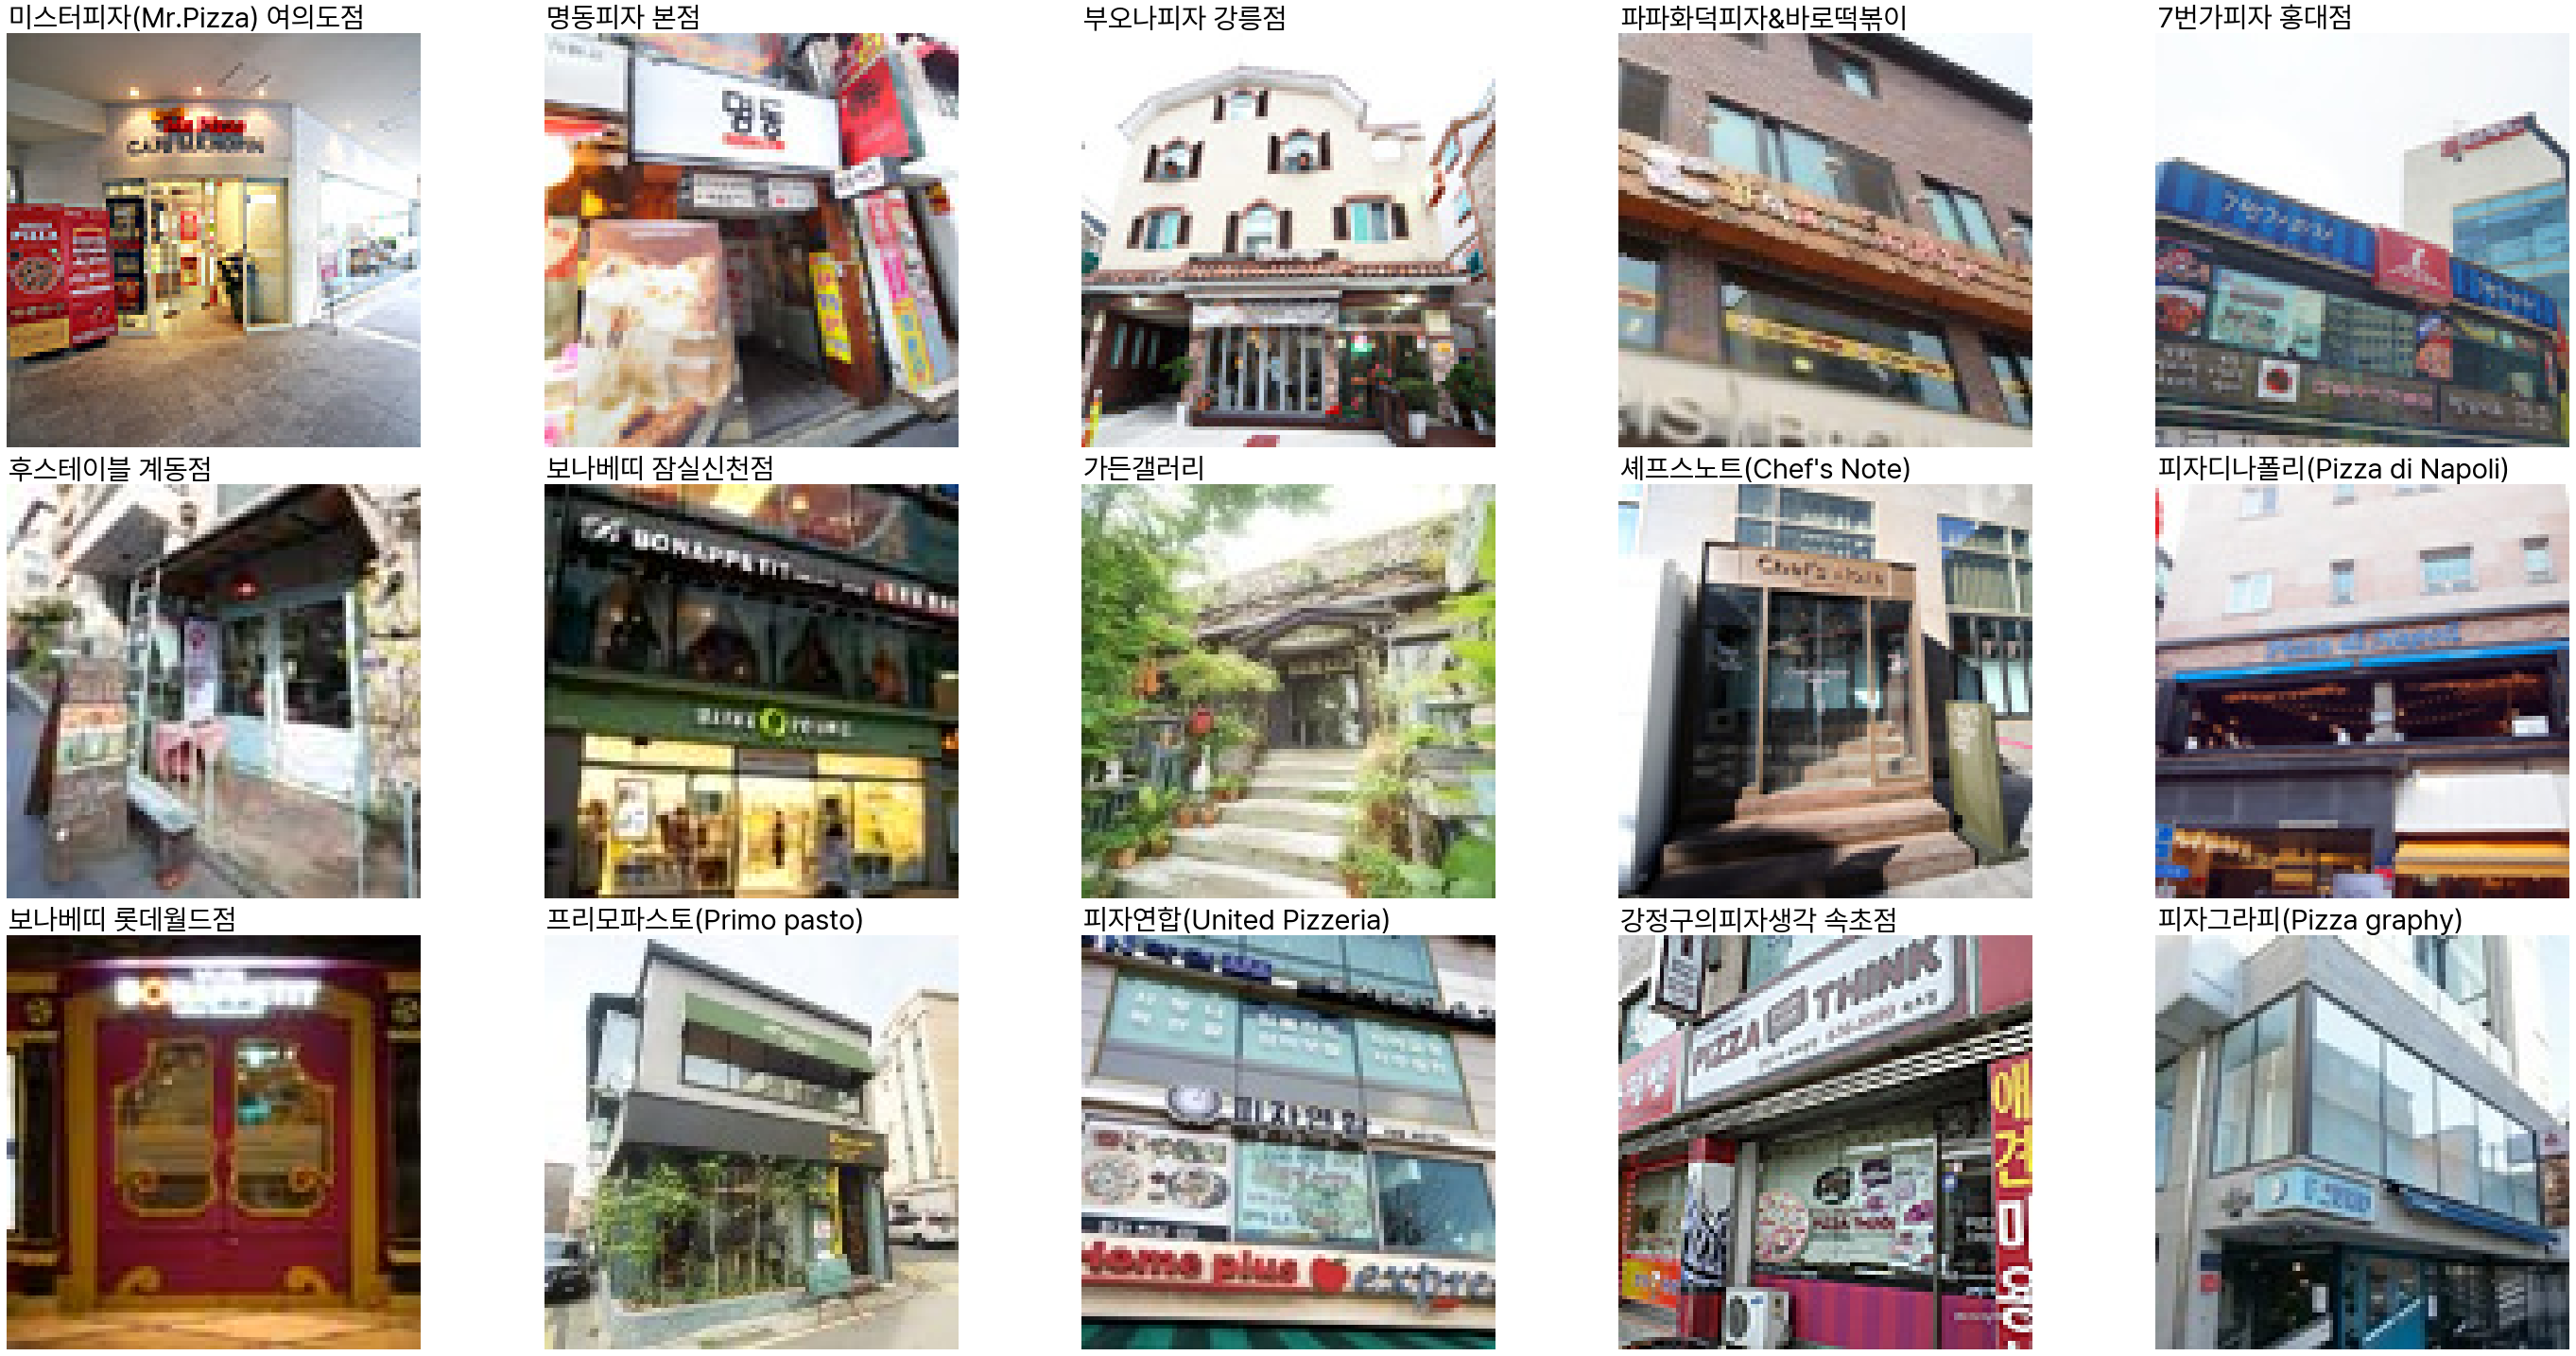

In [17]:
fig, axes = plt.subplots(3, 5, figsize=[40, 20])
for y in range(3):
  for x in range(5):
    axes[y, x].axis(False)
    restaurant = restaurants[y * 5 + x]
    axes[y, x].imshow(restaurant['image'])
    axes[y, x].text(0, -2, restaurant['name'], size=30)
plt.tight_layout()
plt.show()

## 상세 정보 가져오기
주어진 데이터의 링크를 가져오면 상세정보를 가져올 수 있다.

In [18]:
def get_detail(url):
  soup = make_soup(url)
  print(url.split('=')[-1])
  return {
    'acode': url.split('=')[-1],
    **(lambda data: {
      'low_price': int(data[0].get_text().replace(',', '')) if len(data) == 2 else None,
      'high_price': int(data[len(data) - 1].get_text().replace(',', '')),
    } if data and isinstance(data, list) else {})(soup.select('.price strong')),
    **(lambda data: {
      'lat': data.group(1),
      'lng': data.group(2),
    } if data else {})(re.compile(r"LatLng\('([\.\d]+)', '([\.\d]+)'\)").search(str(soup)))
  }

In [19]:
details = [get_detail(base_url + '/Restaurant/Onepage.asp?acode=' + r['acode']) for r in restaurants]
details

F101182
R106770
R200086
B102259
R106818
R106778
R106602
R402653
R106961
R107065
R106798
R106885
F101223
F200093
R107338


[{'acode': 'F101182',
  'low_price': 20000,
  'high_price': 30000,
  'lat': '37.5211410926153',
  'lng': '126.924140402161'},
 {'acode': 'R106770', 'low_price': 10000, 'high_price': 20000},
 {'acode': 'R200086',
  'low_price': 10000,
  'high_price': 20000,
  'lat': '37.7687234616326',
  'lng': '128.8782677883'},
 {'acode': 'B102259'},
 {'acode': 'R106818'},
 {'acode': 'R106778', 'low_price': 10000, 'high_price': 20000},
 {'acode': 'R106602',
  'low_price': 10000,
  'high_price': 20000,
  'lat': '37.5113670821207',
  'lng': '127.083611231167'},
 {'acode': 'R402653', 'low_price': 20000, 'high_price': 30000},
 {'acode': 'R106961',
  'low_price': 30000,
  'high_price': 50000,
  'lat': '37.5109375170423',
  'lng': '127.057645826704'},
 {'acode': 'R107065'},
 {'acode': 'R106798'},
 {'acode': 'R106885',
  'low_price': 10000,
  'high_price': 20000,
  'lat': '37.5758827780297',
  'lng': '126.896217002465'},
 {'acode': 'F101223', 'low_price': 10000, 'high_price': 20000},
 {'acode': 'F200093'},
 


가격을 못 구하길래 직접 들어가 봤더니 업체의 요청에 따라 삭제된 페이지라고 뜬다.  
검색 결과에서만 저렇게 나오는 것 같다


마찬가지로 dataframe으로 변환해보았다.

In [20]:
detail_df = pd.DataFrame(data=details)
detail_df

,acode,low_price,high_price,lat,lng
0,F101182,20000.0,30000.0,37.5211410926153,126.924140402161
1,R106770,10000.0,20000.0,NaN,NaN
2,R200086,10000.0,20000.0,37.7687234616326,128.8782677883
3,B102259,NaN,NaN,NaN,NaN
4,R106818,NaN,NaN,NaN,NaN
5,R106778,10000.0,20000.0,NaN,NaN
6,R106602,10000.0,20000.0,37.5113670821207,127.083611231167
7,R402653,20000.0,30000.0,NaN,NaN
8,R106961,30000.0,50000.0,37.5109375170423,127.057645826704
9,R107065,NaN,NaN,NaN,NaN


검색 페이지에 있는 정보와 머지를 하면 다음과 같은 결과를 얻을 수 있다.

In [21]:
restaurants_without_image = [{key:val for key, val in restaurant.items() if key != 'image'} for restaurant in restaurants]
restaurant_df = pd.DataFrame(data=restaurants_without_image)
restaurant_df

,name,acode,part,menus,address,tel
0,미스터피자(Mr.Pizza) 여의도점,F101182,패스트푸드>피자,"[하프앤하프(R), 치즈스페셜(오리진/R), 치즈스페셜(치즈캡/R)]",서울 영등포구 여의도동 37 아일렉스상가,02-784-0005
1,명동피자 본점,R106770,양식>이탈리아음식,"[뽀빠이 피자, 디아볼라 피자, 크레마 감베리 펜네]",서울 중구 충무로1가 22-2 우림빌딩 지하,02-777-8979
2,부오나피자 강릉점,R200086,양식>패밀리레스토랑,"[화덕 엘레강스 피자, 숯불 바베큐 골드 피자, 빠네 파스타]",강원 강릉시 교동 1822-2,033-651-0324
3,파파화덕피자&바로떡볶이,B102259,분식,"[세트A, 세트B, 세트C]",서울 용산구 청파동2가 63-21 2층,02-704-9626
4,7번가피자 홍대점,R106818,양식,"[Regular, Large, Regular]",서울 마포구 서교동 347-1 2층,02-322-6777
5,후스테이블 계동점,R106778,양식>이탈리아음식,"[감베로니오일, 생모짜렐라피자, 샐러드]",서울 종로구 계동 140-4,02-742-5061
6,보나베띠 잠실신천점,R106602,양식>이탈리아음식,"[카프레제, 고르곤졸라 피자, 안심 스테이크]",서울 송파구 잠실동 184-2 2층,02-423-3520
7,가든갤러리,R402653,양식>이탈리아음식,"[고르곤졸라피자, 커플 A, 커플 B]",경기 남양주시 수석동 143,031-566-7777
8,셰프스노트(Chef's Note),R106961,양식>이탈리아음식,"[아보카도 카프리제 샐러드, 마르게리타 피자, 랍스터 스파게티]",서울 강남구 삼성동 159 오크우드 프리미어 1층,02-556-2135
9,피자디나폴리(Pizza di Napoli),R107065,양식,"[해산물튀김, 치킨크림리조또, 반반 피자]",서울 강남구 신사동 525-24 2층,02-512-3109


In [22]:
merged_df = restaurant_df.merge(detail_df, on='acode')
merged_df

,name,acode,part,menus,address,tel,low_price,high_price,lat,lng
0,미스터피자(Mr.Pizza) 여의도점,F101182,패스트푸드>피자,"[하프앤하프(R), 치즈스페셜(오리진/R), 치즈스페셜(치즈캡/R)]",서울 영등포구 여의도동 37 아일렉스상가,02-784-0005,20000.0,30000.0,37.5211410926153,126.924140402161
1,명동피자 본점,R106770,양식>이탈리아음식,"[뽀빠이 피자, 디아볼라 피자, 크레마 감베리 펜네]",서울 중구 충무로1가 22-2 우림빌딩 지하,02-777-8979,10000.0,20000.0,NaN,NaN
2,부오나피자 강릉점,R200086,양식>패밀리레스토랑,"[화덕 엘레강스 피자, 숯불 바베큐 골드 피자, 빠네 파스타]",강원 강릉시 교동 1822-2,033-651-0324,10000.0,20000.0,37.7687234616326,128.8782677883
3,파파화덕피자&바로떡볶이,B102259,분식,"[세트A, 세트B, 세트C]",서울 용산구 청파동2가 63-21 2층,02-704-9626,NaN,NaN,NaN,NaN
4,7번가피자 홍대점,R106818,양식,"[Regular, Large, Regular]",서울 마포구 서교동 347-1 2층,02-322-6777,NaN,NaN,NaN,NaN
5,후스테이블 계동점,R106778,양식>이탈리아음식,"[감베로니오일, 생모짜렐라피자, 샐러드]",서울 종로구 계동 140-4,02-742-5061,10000.0,20000.0,NaN,NaN
6,보나베띠 잠실신천점,R106602,양식>이탈리아음식,"[카프레제, 고르곤졸라 피자, 안심 스테이크]",서울 송파구 잠실동 184-2 2층,02-423-3520,10000.0,20000.0,37.5113670821207,127.083611231167
7,가든갤러리,R402653,양식>이탈리아음식,"[고르곤졸라피자, 커플 A, 커플 B]",경기 남양주시 수석동 143,031-566-7777,20000.0,30000.0,NaN,NaN
8,셰프스노트(Chef's Note),R106961,양식>이탈리아음식,"[아보카도 카프리제 샐러드, 마르게리타 피자, 랍스터 스파게티]",서울 강남구 삼성동 159 오크우드 프리미어 1층,02-556-2135,30000.0,50000.0,37.5109375170423,127.057645826704
9,피자디나폴리(Pizza di Napoli),R107065,양식,"[해산물튀김, 치킨크림리조또, 반반 피자]",서울 강남구 신사동 525-24 2층,02-512-3109,NaN,NaN,NaN,NaN


### 최종 정리
여기까지의 과정을 다시한번 하나의 함수로 정리할 것이다.

In [23]:
def fetch_restaurants(keyword: str, max_page: int):
  restaurants = search_restaurants(keyword, max_page)
  details = [get_detail(base_url + '/Restaurant/Onepage.asp?acode=' + r['acode']) for r in restaurants]
  restaurant_df = pd.DataFrame(data=restaurants)
  detail_df = pd.DataFrame(data=details)
  df = restaurant_df.merge(detail_df, on='acode')
  df.lat = df.lat.astype(float)
  df.lng = df.lng.astype(float)
  return df

In [24]:
final_df = fetch_restaurants('피자', 10)
final_df

F101182
R106770
R200086
B102259
R106818
R106778
R106602
R402653
R106961
R107065
R106798
R106885
F101223
F200093
R107338
R107108
R106688
F101195
R106780
R107175
R107227
R106572
R106583
R107206
R106997
R402758
R106491
R106998
R106999
R107333
R106597
F101149
F101196
F300237
R107411
R200102
R107442
R600304
F600369
R107101
R106432
D600742
D103399
R106853
F101199
F101201
R600269
R107082
R106720
R107231
R107006
R106849
R700332
R402566
R600218
R107000
R107319
D402251
F101221
R300203
R300202
R106866
R106805
R107054
R106784
R106891
D600728
R107339
D500981
R402632
R200074
R106718
R106775
F400636
R106758
R700329
R600222
R106880
R106795
R106707
R106801
D103499
B102275
R300182
R402760
F400634
R107242
R106774
R106911
R106680
R600244
F101203
R106798
R106885
J300477
R600219
R107217
T400636
R107208
R106806
R107151
R402677
R107128
R200088
R200084
R106573
R107251
R107285
R106682
D103105
R700328
R107335
T168312
R300186
R402608
J600545
B300009
F101104
F101096
F101099
F101102
F101098
F101101
F101097
F101100


,name,acode,part,menus,address,tel,low_price,high_price,lat,lng
0,미스터피자(Mr.Pizza) 여의도점,F101182,패스트푸드>피자,"[하프앤하프(R), 치즈스페셜(오리진/R), 치즈스페셜(치즈캡/R)]",서울 영등포구 여의도동 37 아일렉스상가,02-784-0005,20000.0,30000.0,37.521141,126.924140
1,명동피자 본점,R106770,양식>이탈리아음식,"[뽀빠이 피자, 디아볼라 피자, 크레마 감베리 펜네]",서울 중구 충무로1가 22-2 우림빌딩 지하,02-777-8979,10000.0,20000.0,NaN,NaN
2,부오나피자 강릉점,R200086,양식>패밀리레스토랑,"[화덕 엘레강스 피자, 숯불 바베큐 골드 피자, 빠네 파스타]",강원 강릉시 교동 1822-2,033-651-0324,10000.0,20000.0,37.768723,128.878268
3,파파화덕피자&바로떡볶이,B102259,분식,"[세트A, 세트B, 세트C]",서울 용산구 청파동2가 63-21 2층,02-704-9626,NaN,NaN,NaN,NaN
4,7번가피자 홍대점,R106818,양식,"[Regular, Large, Regular]",서울 마포구 서교동 347-1 2층,02-322-6777,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
149,파파존스-수내점,H492110,패스트푸드>피자,"[슈퍼파파스, 아이리쉬포테이토]",경기 성남시 분당구 정자동 54-2 금성프라자 1층,031-726-2842,20000.0,30000.0,NaN,NaN
150,파파존스-마포점,F101091,패스트푸드>피자,"[슈퍼파파스, 아이리쉬포테이토]",서울 마포구 공덕동 426-19,02-3275-0956,20000.0,30000.0,NaN,NaN
151,파파존스-서현점,F400622,패스트푸드>피자,"[슈퍼파파스, 아이리쉬포테이토]",경기 성남시 분당구 서현동 81-4 1층,031-709-7305,20000.0,30000.0,NaN,NaN
152,파파존스-왕십리점,F101087,패스트푸드>피자,"[슈퍼파파스(Super Papa's), 아이리쉬 포테이토(Potato of the ...",서울 성동구 응봉동 100 대림상가 1층,02-2296-0050,20000.0,30000.0,NaN,NaN


마지막으로, 위경도가 있으니까 지도에 마커를 찍어서 표시를 할 것이다.

In [25]:
# https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium thanks
# https://stackoverflow.com/questions/63152298/updating-folium-changed-the-popup-box-width thanks

m = folium.Map(final_df[['lat', 'lng']].mean().values.tolist())
for index in final_df.index:
  if (np.isnan(final_df.loc[index, 'lat'])): continue
  folium.Marker(
    location=[final_df.loc[index, 'lat'], final_df.loc[index, 'lng']],
    fill=True,
    popup=folium.Popup(final_df.loc[index, 'name'], max_width=400),
    ).add_to(m)
m.fit_bounds([
  final_df[['lat', 'lng']].min().values.tolist(),
  final_df[['lat', 'lng']].max().values.tolist(),
]) 
m

실제 페이지에서 직접 보면 위치가 똑같다.  
성공!

# OpenAPI
대중교통의 노선 정보를 가져올 것이다.

* 노선번호목록조회
  * http://apis.data.go.kr/6410000/busrouteservice/getBusRouteList?serviceKey={서비스키}&keyword={노선번호}
* 운행지역별노선번호목록조회	
  * http://apis.data.go.kr/6410000/busrouteservice/getAreaBusRouteList?serviceKey={서비스키}&areaId={운행지역id}&keyword={노선번호}
* 노선정보항목조회
  * http://apis.data.go.kr/6410000/busrouteservice/getBusRouteInfoItem?serviceKey={서비스키}&routeId={노선id}
* 경유정류소목록조회
  * 노선이 어떤 곳을 경우하는지 볼 수 있다.
  * http://apis.data.go.kr/6410000/busrouteservice/getBusRouteStationList?serviceKey={서비스키}&routeId={노선id}
* 노선형상정보목록조회
  * 노선의 위치 정보(lat, lng)를 가져올 수 있다.
  * http://apis.data.go.kr/6410000/busrouteservice/getBusRouteLineList?serviceKey={서비스키}&routeId={노선id}

In [26]:
# 안산에서 타본 거의 유일한 버스 101번 버스이다.
bus_number = 101
service_key = 'l3VGjDP4WazQB0s98DMI%2BjzhoG4XYnCjwfLG%2Fa%2B6nnaNyFEkyIZnbKaQmwwLbobhN4U4FRXRnYVuFH99qdcovQ%3D%3D'

## 노선(버스) 번호에 따른 정보 가져오기
101번 버스가 하나만 있을 줄 알았는데, 안산 101번, 광명서울안양 101번 등.. 여러가지가 있는 것 같다.  
따라서 따로 필터링이 필요할 것 같다.

In [27]:
res = requests.get('http://apis.data.go.kr/6410000/busrouteservice/getBusRouteList?serviceKey={service_key}&keyword={keyword}'.format(service_key=service_key, keyword=bus_number))
soup = BeautifulSoup(res.text)
print(soup.prettify())

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<response>
 <commsgheader>
 </commsgheader>
 <msgheader>
  <querytime>
   2021-09-16 11:47:45.522
  </querytime>
  <resultcode>
   0
  </resultcode>
  <resultmessage>
   정상적으로 처리되었습니다.
  </resultmessage>
 </msgheader>
 <msgbody>
  <busroutelist>
   <districtcd>
    2
   </districtcd>
   <regionname>
    안산
   </regionname>
   <routeid>
    217000002
   </routeid>
   <routename>
    101
   </routename>
   <routetypecd>
    13
   </routetypecd>
   <routetypename>
    일반형시내버스
   </routetypename>
  </busroutelist>
  <busroutelist>
   <districtcd>
    2
   </districtcd>
   <regionname>
    광명,서울,안양
   </regionname>
   <routeid>
    213000016
   </routeid>
   <routename>
    101
   </routename>
   <routetypecd>
    13
   </routetypecd>
   <routetypename>
    일반형시내버스
   </routetypename>
  </busroutelist>
  <busroutelist>
   <districtcd>
    2
   </districtcd>
   <regionname>
    김포
   </regionname>
   <routeid>
    232000032
   </routeid

In [28]:
# 지역 이름이 안산인 정보를 가져왔다.
route = [route for route in soup.select('busRouteList') if route.select_one('regionName').get_text().strip() == "안산"][0]
route

<busroutelist><districtcd>2</districtcd><regionname>안산</regionname><routeid>217000002</routeid><routename>101</routename><routetypecd>13</routetypecd><routetypename>일반형시내버스</routetypename></busroutelist>

In [29]:
# routeId를 받아낸 다음
route_id = route.find('routeid').get_text()
route_id

'217000002'

## 노선의 위치정보 가져오기

In [30]:
res = requests.get('http://apis.data.go.kr/6410000/busrouteservice/getBusRouteLineList?serviceKey={service_key}&routeId={route_id}'.format(service_key=service_key, route_id=route_id))
soup2 = BeautifulSoup(res.text)
print(soup2.prettify())

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<response>
 <commsgheader>
 </commsgheader>
 <msgheader>
  <querytime>
   2021-09-16 11:47:45.710
  </querytime>
  <resultcode>
   0
  </resultcode>
  <resultmessage>
   정상적으로 처리되었습니다.
  </resultmessage>
 </msgheader>
 <msgbody>
  <busroutelinelist>
   <lineseq>
    1
   </lineseq>
   <x>
    126.75359
   </x>
   <y>
    37.31367
   </y>
  </busroutelinelist>
  <busroutelinelist>
   <lineseq>
    2
   </lineseq>
   <x>
    126.75391
   </x>
   <y>
    37.31358
   </y>
  </busroutelinelist>
  <busroutelinelist>
   <lineseq>
    3
   </lineseq>
   <x>
    126.75476
   </x>
   <y>
    37.31333
   </y>
  </busroutelinelist>
  <busroutelinelist>
   <lineseq>
    4
   </lineseq>
   <x>
    126.75499
   </x>
   <y>
    37.31327
   </y>
  </busroutelinelist>
  <busroutelinelist>
   <lineseq>
    5
   </lineseq>
   <x>
    126.7571
   </x>
   <y>
    37.31267
   </y>
  </busroutelinelist>
  <busroutelinelist>
   <lineseq>
    6
   </linese

In [31]:
seq = [seq.get_text() for seq in soup2.select('busRouteLineList lineseq')]
lat = [seq.get_text() for seq in soup2.select('busRouteLineList y')]
lng = [seq.get_text() for seq in soup2.select('busRouteLineList x')]
df_data = {
  'seq': seq,
  'lat': lat,
  'lng': lng
}
route_location_df = pd.DataFrame(data=df_data)
route_location_df.lat = route_location_df.lat.astype(float)
route_location_df.lng = route_location_df.lng.astype(float)
route_location_df

,seq,lat,lng
0,1,37.31367,126.75359
1,2,37.31358,126.75391
2,3,37.31333,126.75476
3,4,37.31327,126.75499
4,5,37.31267,126.75710
...,...,...,...
1158,1159,37.31383,126.75323
1159,1160,37.31403,126.75254
1160,1161,37.31398,126.75251
1161,1162,37.31376,126.75327


## 노선 정류소 정보 가져오기

In [32]:
res = requests.get('http://apis.data.go.kr/6410000/busrouteservice/getBusRouteStationList?serviceKey={service_key}&routeId={route_id}'.format(service_key=service_key, route_id=route_id))
soup3 = BeautifulSoup(res.text)
print(soup3.prettify())

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<response>
 <commsgheader>
 </commsgheader>
 <msgheader>
  <querytime>
   2021-09-16 11:47:46.413
  </querytime>
  <resultcode>
   0
  </resultcode>
  <resultmessage>
   정상적으로 처리되었습니다.
  </resultmessage>
 </msgheader>
 <msgbody>
  <busroutestationlist>
   <centeryn>
    N
   </centeryn>
   <districtcd>
    2
   </districtcd>
   <mobileno>
    18015
   </mobileno>
   <regionname>
    안산
   </regionname>
   <stationid>
    217000188
   </stationid>
   <stationname>
    경원여객
   </stationname>
   <x>
    126.7535333
   </x>
   <y>
    37.3135833
   </y>
   <stationseq>
    1
   </stationseq>
   <turnyn>
    N
   </turnyn>
  </busroutestationlist>
  <busroutestationlist>
   <centeryn>
    N
   </centeryn>
   <districtcd>
    2
   </districtcd>
   <mobileno>
    18021
   </mobileno>
   <regionname>
    안산
   </regionname>
   <stationid>
    217000187
   </stationid>
   <stationname>
    대화페인트앞
   </stationname>
   <x>
    126.7578833
  

In [33]:
df_data = {
  'name': [station.get_text() for station in soup3.select('busRouteStationList stationName')],
  'lat': [station.get_text() for station in soup3.select('busRouteStationList y')],
  'lng': [station.get_text() for station in soup3.select('busRouteStationList x')],
}
station_df = pd.DataFrame(data=df_data)
station_df.lat = station_df.lat.astype(float)
station_df.lng = station_df.lng.astype(float)
station_df

,name,lat,lng
0,경원여객,37.313583,126.753533
1,대화페인트앞,37.312350,126.757883
2,인텍전자,37.311867,126.759550
3,디에스테크,37.310150,126.759933
4,환경사업소.유니켐,37.304983,126.758450
...,...,...,...
171,유니캠,37.306950,126.759667
172,㈜디아이씨,37.310100,126.760250
173,위아주식회사,37.312600,126.757633
174,경원여객종점,37.313767,126.753533


이제 `route_location_df`에 있는 정보를 가져와서 지도에 선으로 그리고, `station_df`에 있는 것을 마커로 찍을 것이다.

In [34]:
import folium
m = folium.Map(route_location_df[['lat', 'lng']].mean().values.tolist())
folium.PolyLine(route_location_df[['lat', 'lng']]).add_to(m)
popup = folium.Popup(min_width=200, max_width=200)
for index in station_df.index:
  folium.Marker(
    location=[station_df.loc[index, 'lat'], station_df.loc[index, 'lng']],
    fill=True,
    popup=folium.Popup(station_df.loc[index, 'name'], max_width=400),
    ).add_to(m)
m.fit_bounds([
  route_location_df[['lat', 'lng']].min().values.tolist(),
  route_location_df[['lat', 'lng']].max().values.tolist(),
]) 
m